In [22]:
!which python

/home/e20363/miniconda3/envs/museformer/bin/python


In [23]:
!export FYP_MUSICGEN_ROOT=/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen

In [24]:
!BASE=$FYP_MUSICGEN_ROOT/data/museformer_baseline
!SAMPLE=$BASE/sample

!mkdir -p "$SAMPLE"/{00_raw,01_parsed_results,02_a_midiminer,02_b_midiminer_results,03_compressed6,logs,tmp}

!echo "FYP_MUSICGEN_ROOT=$FYP_MUSICGEN_ROOT"
!echo "SAMPLE=$SAMPLE"
!find "$SAMPLE" -maxdepth 1 -type d | sort

mkdir: cannot create directory ‘/00_raw’: Permission denied
mkdir: cannot create directory ‘/01_parsed_results’: Permission denied
mkdir: cannot create directory ‘/02_a_midiminer’: Permission denied
mkdir: cannot create directory ‘/02_b_midiminer_results’: Permission denied
mkdir: cannot create directory ‘/03_compressed6’: Permission denied
mkdir: cannot create directory ‘/logs’: Permission denied
FYP_MUSICGEN_ROOT=
SAMPLE=
find: ‘’: No such file or directory


In [26]:
import os, hashlib, shutil, random
from pathlib import Path
import pandas as pd

ROOT = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen")
LMD_ROOT = ROOT / "data" / "raw" / "lmd_full"
SAMPLE_DIR = ROOT / "data" / "museformer_baseline" / "sample"
OUT_RAW = SAMPLE_DIR / "00_raw"
LOGS = SAMPLE_DIR / "logs"
LOGS.mkdir(parents=True, exist_ok=True)
OUT_RAW.mkdir(parents=True, exist_ok=True)

RAW_MANIFEST = LOGS / "raw_manifest.csv"
SAMPLE_MANIFEST = LOGS / "sample_manifest.csv"

SEED = 42
N_PER_PREFIX = 200   # change as you like (e.g., 5 or 10)
random.seed(SEED)

# 1) collect MIDI files
midi_files = []
for ext in ("*.mid", "*.midi", "*.MID", "*.MIDI"):
    midi_files.extend(LMD_ROOT.rglob(ext))

rows = []
for p in midi_files:
    rel = p.relative_to(LMD_ROOT).as_posix()
    prefix = rel.split("/", 1)[0]
    size_bytes = p.stat().st_size

    # stable file_id from rel path (12 hex)
    file_id = hashlib.md5(rel.encode("utf-8")).hexdigest()[:12]
    # keep full md5 too (useful for uniqueness)
    rel_md5 = hashlib.md5(rel.encode("utf-8")).hexdigest()

    rows.append({
        "file_id": file_id,
        "raw_path": str(p),
        "rel_path": rel,
        "folder_prefix": prefix,
        "size_bytes": size_bytes,
        "rel_md5": rel_md5,
    })

df = pd.DataFrame(rows).sort_values(["folder_prefix", "rel_path"]).reset_index(drop=True)
df.to_csv(RAW_MANIFEST, index=False)
print("Total MIDI files:", len(df))
print("Saved:", RAW_MANIFEST)

# 2) sample N_PER_PREFIX per prefix
sample_parts = []
for pref in sorted(df["folder_prefix"].unique()):
    sub = df[df["folder_prefix"] == pref]
    take = min(N_PER_PREFIX, len(sub))
    if take > 0:
        rs = random.randint(0, 10**9)
        sample_parts.append(sub.sample(n=take, random_state=rs))

sample_df = pd.concat(sample_parts, ignore_index=True) if sample_parts else df.head(0)
sample_df = sample_df.sample(frac=1, random_state=SEED).reset_index(drop=True)

# 3) copy sampled files into 00_raw with stable names
copied = 0
for _, r in sample_df.iterrows():
    src = Path(r["raw_path"])
    dst = OUT_RAW / f'{r["file_id"]}__{r["rel_md5"]}.mid'
    if not dst.exists():
        shutil.copy2(src, dst)
    copied += 1

sample_df["sampled_filename"] = sample_df.apply(lambda r: f'{r["file_id"]}__{r["rel_md5"]}.mid', axis=1)
sample_df.to_csv(SAMPLE_MANIFEST, index=False)

print("Sample rows:", len(sample_df))
print("Copied files:", copied, "->", OUT_RAW)
print("\nSample counts per prefix (top 10):")
print(sample_df["folder_prefix"].value_counts().head(10))

Total MIDI files: 178561
Saved: /scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/logs/raw_manifest.csv
Sample rows: 3200
Copied files: 3200 -> /scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/00_raw

Sample counts per prefix (top 10):
folder_prefix
b    200
c    200
a    200
4    200
1    200
d    200
0    200
7    200
3    200
6    200
Name: count, dtype: int64


midiminer find melody

In [27]:
import os, traceback
from pathlib import Path
import pandas as pd
import numpy as np
import miditoolkit

ROOT = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen")
SAMPLE = ROOT / "data" / "museformer_baseline" / "sample"
IN_DIR = SAMPLE / "00_raw"
OUT_OK = SAMPLE / "01_parsed_results"
LOGS = SAMPLE / "logs"
OUT_OK.mkdir(parents=True, exist_ok=True)
LOGS.mkdir(parents=True, exist_ok=True)

MANIFEST = LOGS / "manifest.csv"

def get_time_sigs(midi: miditoolkit.MidiFile):
    if not midi.time_signature_changes:
        return []
    s = []
    for ts in midi.time_signature_changes:
        s.append(f"{ts.numerator}/{ts.denominator}")
    # unique but keep order
    out = []
    for x in s:
        if x not in out:
            out.append(x)
    return out

def get_tempo_stats(midi: miditoolkit.MidiFile):
    # miditoolkit stores tempo changes; if none, assume 120
    tempos = [t.tempo for t in getattr(midi, "tempo_changes", [])] or [120.0]
    return float(np.min(tempos)), float(np.max(tempos))

def get_note_stats(midi: miditoolkit.MidiFile):
    pitches = []
    durs = []
    onsets = set()
    n_notes = 0
    programs = set()
    has_drum = False
    n_tracks = len(midi.instruments)

    for inst in midi.instruments:
        if inst.is_drum:
            has_drum = True
        else:
            programs.add(int(inst.program))
        for n in inst.notes:
            n_notes += 1
            pitches.append(n.pitch)
            # duration in ticks; convert to beats using ticks_per_beat
            durs.append((n.end - n.start) / midi.ticks_per_beat)
            onsets.add(n.start)

    if n_notes == 0:
        return None

    return {
        "pitch_min": float(np.min(pitches)),
        "pitch_max": float(np.max(pitches)),
        "max_note_dur_beats": float(np.max(durs)),
        "num_notes": float(n_notes),
        "num_tracks": float(n_tracks),
        "distinct_onsets": float(len(onsets)),
        "programs": sorted(list(programs)),
        "has_drum": bool(has_drum),
    }

rows = []
files = sorted(list(IN_DIR.glob("*.mid"))) + sorted(list(IN_DIR.glob("*.midi")))
print("Parsing files:", len(files))

for p in files:
    file_id = p.name.split("__", 1)[0]
    row = {
        "file_id": file_id,
        "raw_path": str(p),
        "stage": "01_parsed_meta",
        "status": "ok",
        "drop_reason": "",
        "error_msg": "",
        "time_signatures": "",
        "is_4_4_only": "",
        "tempo_min": "",
        "tempo_max": "",
        "pitch_min": "",
        "pitch_max": "",
        "max_note_dur_beats": "",
        "num_notes": "",
        "num_tracks": "",
        "distinct_onsets": "",
        "programs": "",
        "has_drum": "",
    }

    try:
        midi = miditoolkit.MidiFile(str(p))
        ts = get_time_sigs(midi)
        row["time_signatures"] = ",".join(ts) if ts else ""
        row["is_4_4_only"] = bool(ts and all(x == "4/4" for x in ts)) if ts else False

        tmin, tmax = get_tempo_stats(midi)
        row["tempo_min"] = tmin
        row["tempo_max"] = tmax

        ns = get_note_stats(midi)
        if ns is None:
            row["status"] = "drop"
            row["drop_reason"] = "no_notes"
        else:
            row.update(ns)

        # copy ok files to 01_parsed_results
        if row["status"] == "ok":
            dst = OUT_OK / p.name
            if not dst.exists():
                dst.write_bytes(p.read_bytes())

    except Exception as e:
        row["status"] = "fail"
        row["drop_reason"] = "parse_error"
        row["error_msg"] = repr(e)

    rows.append(row)

df = pd.DataFrame(rows)
df.to_csv(MANIFEST, index=False)
print("Saved manifest:", MANIFEST)
print("OK:", (df["status"]=="ok").sum(), "FAIL:", (df["status"]=="fail").sum(), "DROP:", (df["status"]=="drop").sum())
print("Parsed OK files copied to:", OUT_OK)


Parsing files: 3200
Saved manifest: /scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/logs/manifest.csv
OK: 3136 FAIL: 60 DROP: 4
Parsed OK files copied to: /scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/01_parsed_results


copying original files

In [28]:
from pathlib import Path
import json
import shutil
import pandas as pd
from datetime import datetime

RAW_DIR = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/00_raw")
DEST_DIR = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/02_b_midiminer_results")
MANIFEST = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/logs/manifest.csv")
MIDIMINER_JSON = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/02_a_midiminer/program_result.json")

STAGE_NAME = "02_b_midiminer"
DROP_REASON = "no_melody_midiminer"


def main():
    DEST_DIR.mkdir(parents=True, exist_ok=True)

    # --- load midiminer results ---
    # format: { "<path/or/basename.mid>": {"melody": 73, "bass": 34, "drum": 0, ...}, ... }
    with MIDIMINER_JSON.open("r") as f:
        mm = json.load(f)

    # Map: basename -> roles (only if melody exists)
    basename_to_roles = {}
    for path_str, roles in mm.items():
        b = Path(path_str).name
        if isinstance(roles, dict) and ("melody" in roles):
            basename_to_roles[b] = roles

    keep_basenames = set(basename_to_roles.keys())
    print(f"[MIDIMINER] entries_with_melody={len(keep_basenames)} total_json_entries={len(mm)}")

    # --- copy originals into 02_b_midiminer_results ---
    copied = 0
    skipped = 0
    missing = 0

    for b in sorted(keep_basenames):
        src = RAW_DIR / b
        dst = DEST_DIR / b
        if not src.exists():
            missing += 1
            continue
        if dst.exists():
            skipped += 1
            continue
        shutil.copy2(src, dst)
        copied += 1

    print(f"[COPY] copied={copied} skipped(existing)={skipped} missing_in_raw={missing}")

    # --- update manifest ---
    df = pd.read_csv(MANIFEST)

    # backup first
    backup = MANIFEST.with_suffix(f".backup_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
    df.to_csv(backup, index=False)
    print("[MANIFEST] backup:", backup)

    # add basename column if not exists (helps matching)
    if "raw_basename" not in df.columns:
        df["raw_basename"] = df["raw_path"].astype(str).map(lambda p: Path(p).name)

    # add new columns if missing
    new_cols_defaults = {
        "midiminer_has_melody": pd.NA,
        "midiminer_melody_program": pd.NA,
        "midiminer_bass_program": pd.NA,
        "midiminer_drum_program": pd.NA,
        "midiminer_roles_json": pd.NA,
        "midiminer_stage": pd.NA,
        "midiminer_out_path": pd.NA,
    }
    for c, default in new_cols_defaults.items():
        if c not in df.columns:
            df[c] = default

    # Only advance rows that are currently parse-ok at stage 01_parsed_meta
    parse_ok = df["status"].astype(str).eq("ok") & df["stage"].astype(str).eq("01_parsed_meta")

    has_melody = parse_ok & df["raw_basename"].isin(keep_basenames)
    no_melody = parse_ok & (~df["raw_basename"].isin(keep_basenames))

    df.loc[has_melody, "midiminer_has_melody"] = True
    df.loc[no_melody, "midiminer_has_melody"] = False
    df.loc[parse_ok, "midiminer_stage"] = STAGE_NAME

    # roles/program info for kept files
    for idx in df.index[has_melody]:
        b = df.at[idx, "raw_basename"]
        roles = basename_to_roles.get(b, {})

        df.at[idx, "midiminer_roles_json"] = json.dumps(roles, sort_keys=True)
        df.at[idx, "midiminer_melody_program"] = roles.get("melody", pd.NA)
        df.at[idx, "midiminer_bass_program"] = roles.get("bass", pd.NA)
        df.at[idx, "midiminer_drum_program"] = roles.get("drum", pd.NA)
        df.at[idx, "midiminer_out_path"] = str(DEST_DIR / b)

    # advance pipeline stage/status/drop_reason
    df.loc[parse_ok, "stage"] = STAGE_NAME

    df.loc[has_melody, "status"] = "ok"
    df.loc[has_melody, "drop_reason"] = pd.NA
    df.loc[has_melody, "error_msg"] = pd.NA

    # IMPORTANT: use "drop" (consistent with your parse step), not "dropped"
    df.loc[no_melody, "status"] = "drop"
    df.loc[no_melody, "drop_reason"] = DROP_REASON
    df.loc[no_melody, "error_msg"] = pd.NA

    df.to_csv(MANIFEST, index=False)
    print("[MANIFEST] updated:", MANIFEST)
    print("[SUMMARY] parse_ok:", int(parse_ok.sum()), "has_melody:", int(has_melody.sum()), "no_melody:", int(no_melody.sum()))


if __name__ == "__main__":
    main()


[MIDIMINER] entries_with_melody=1795 total_json_entries=1795
[COPY] copied=1795 skipped(existing)=0 missing_in_raw=0
[MANIFEST] backup: /scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/logs/manifest.backup_20260115_124935.csv
[MANIFEST] updated: /scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/logs/manifest.csv
[SUMMARY] parse_ok: 3136 has_melody: 1795 no_melody: 1341


compresssing to 6

In [29]:
from pathlib import Path
import json
import pandas as pd

MANIFEST = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/logs/manifest.csv")

RAW_DIR = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/00_raw")
IN_DIR  = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/02_b_midiminer_results")
OUT_DIR = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/03_compressed6")
OUT_DIR.mkdir(parents=True, exist_ok=True)

MIDIMINER_JSON = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/02_a_midiminer/program_result.json")

df = pd.read_csv(MANIFEST)

# Load midi-miner roles: keys are paths, we match by basename
mm = json.loads(MIDIMINER_JSON.read_text())
roles_by_basename = {Path(k).name: v for k, v in mm.items()}

print("manifest rows:", len(df))
print("midiminer entries:", len(roles_by_basename))


manifest rows: 3200
midiminer entries: 1795


In [30]:
import math
from collections import defaultdict
import miditoolkit

# Output canonical programs (0-127)
CANON_PROG = {
    "square_synth": 80,
    "piano": 0,
    "guitar": 24,
    "string": 48,
    "bass": 32,
}

# GM family ranges (0-127)
# Replace your current FAMILY_RANGES with this (0-127)
FAMILY_RANGES = {
    "piano":  [(0, 7)],
    "guitar": [(24, 31)],
    # strings + synthstrings + synth pads (88-95)
    "string": [(40, 51), (88, 95)],
}


POLYPHONY_CAP = {
    "piano": 10,
    "guitar": 6,
    "string": 6,
}

def note_stats(notes):
    if not notes:
        return {"n": 0, "mean_pitch": None}
    pitches = [n.pitch for n in notes]
    return {"n": len(notes), "mean_pitch": sum(pitches)/len(pitches)}

def pick_best_melody(cands):
    # cands: list of (instrument, stats)
    if not cands:
        return None
    # take top-3 by note count, pick the one with highest mean pitch
    cands = sorted(cands, key=lambda x: x[1]["n"], reverse=True)[:3]
    cands = sorted(cands, key=lambda x: (x[1]["mean_pitch"] if x[1]["mean_pitch"] is not None else -1), reverse=True)
    return cands[0][0]

def pick_best_bass(cands):
    if not cands:
        return None
    cands = sorted(cands, key=lambda x: x[1]["n"], reverse=True)
    return cands[0][0]

def in_family(program, fam):
    ranges = FAMILY_RANGES[fam]
    for lo, hi in ranges:
        if lo <= program <= hi:
            return True
    return False


def dedupe_exact(notes):
    # key: (start, end, pitch) keep max velocity
    best = {}
    for n in notes:
        k = (int(n.start), int(n.end), int(n.pitch))
        if k not in best or n.velocity > best[k].velocity:
            best[k] = n
    out = list(best.values())
    out.sort(key=lambda n: (n.start, n.pitch, n.end))
    return out

def trim_same_pitch_overlaps(notes):
    # for each pitch: sort by start, trim previous end if overlap
    by_pitch = defaultdict(list)
    for n in notes:
        by_pitch[int(n.pitch)].append(n)

    out = []
    for p, ns in by_pitch.items():
        ns.sort(key=lambda n: (n.start, n.end))
        prev = None
        for n in ns:
            if prev is None:
                prev = n
                continue
            if n.start < prev.end:
                # trim prev end
                prev.end = int(n.start)
            if prev.end > prev.start:
                out.append(prev)
            prev = n
        if prev is not None and prev.end > prev.start:
            out.append(prev)

    out.sort(key=lambda n: (n.start, n.pitch, n.end))
    return out

def cap_polyphony_by_onset(notes, cap):
    # group by exact start tick
    by_start = defaultdict(list)
    for n in notes:
        by_start[int(n.start)].append(n)

    out = []
    for s, ns in by_start.items():
        if len(ns) <= cap:
            out.extend(ns)
        else:
            # keep top by velocity, tie by pitch
            ns.sort(key=lambda n: (n.velocity, n.pitch), reverse=True)
            out.extend(ns[:cap])

    out.sort(key=lambda n: (n.start, n.pitch, n.end))
    return out

def enforce_monophony(notes, mode="highest"):
    # at each onset keep exactly 1 note (highest or lowest pitch)
    by_start = defaultdict(list)
    for n in notes:
        by_start[int(n.start)].append(n)

    starts = sorted(by_start.keys())
    chosen = []
    for s in starts:
        ns = by_start[s]
        if mode == "highest":
            pick = max(ns, key=lambda n: (n.pitch, n.velocity))
        else:
            pick = min(ns, key=lambda n: (n.pitch, -n.velocity))
        chosen.append(pick)

    # trim overlaps between chosen notes (regardless of pitch)
    chosen.sort(key=lambda n: (n.start, n.end))
    out = []
    prev = None
    for n in chosen:
        if prev is None:
            prev = n
            continue
        if n.start < prev.end:
            prev.end = int(n.start)
        if prev.end > prev.start:
            out.append(prev)
        prev = n
    if prev is not None and prev.end > prev.start:
        out.append(prev)

    out.sort(key=lambda n: (n.start, n.pitch, n.end))
    return out

def build_empty_output_midi(src_midi):
    out = miditoolkit.MidiFile()
    out.ticks_per_beat = src_midi.ticks_per_beat
    out.tempo_changes = src_midi.tempo_changes
    out.time_signature_changes = src_midi.time_signature_changes
    out.key_signature_changes = getattr(src_midi, "key_signature_changes", [])
    out.markers = getattr(src_midi, "markers", [])
    out.lyrics = getattr(src_midi, "lyrics", [])
    return out

def compress_to_6tracks(midi_path: Path, roles: dict, keep_top_k=2):
    midi = miditoolkit.MidiFile(str(midi_path))

    # Separate instruments
    drums = [inst for inst in midi.instruments if inst.is_drum]
    non_drums = [inst for inst in midi.instruments if not inst.is_drum]

    # Role programs from midiminer
    mel_prog = roles.get("melody", None)
    bass_prog = roles.get("bass", None)

    def collect_candidates(target_prog):
        if target_prog is None:
            return []
        cands_exact = []
        cands_offby1 = []
        for inst in non_drums:
            st = note_stats(inst.notes)
            if inst.program == target_prog:
                cands_exact.append((inst, st))
            elif inst.program == target_prog - 1:
                cands_offby1.append((inst, st))
        return cands_exact if cands_exact else cands_offby1

    mel_cands = collect_candidates(mel_prog)
    bass_cands = collect_candidates(bass_prog)

    melody_inst = pick_best_melody(mel_cands)
    bass_inst = pick_best_bass(bass_cands)

    used_ids = set()
    if melody_inst is not None:
        used_ids.add(id(melody_inst))
    if bass_inst is not None:
        used_ids.add(id(bass_inst))
    for d in drums:
        used_ids.add(id(d))

    # Remaining instruments → families
    fam_insts = {"piano": [], "guitar": [], "string": []}
    for inst in non_drums:
        if id(inst) in used_ids:
            continue
        for fam in fam_insts.keys():
            if in_family(inst.program, fam):
                fam_insts[fam].append(inst)
                break

    # Select top-K by activity (note count)
    for fam in fam_insts:
        fam_insts[fam] = sorted(fam_insts[fam], key=lambda inst: len(inst.notes), reverse=True)[:keep_top_k]

    # Gather notes per target
    notes_out = {
        "square_synth": list(melody_inst.notes) if melody_inst else [],
        "bass": list(bass_inst.notes) if bass_inst else [],
        "drum": [],
        "piano": [],
        "guitar": [],
        "string": [],
    }
    for d in drums:
        notes_out["drum"].extend(d.notes)
    for fam in ["piano", "guitar", "string"]:
        for inst in fam_insts[fam]:
            notes_out[fam].extend(inst.notes)

    # Clean each target
    def clean_track(name, notes):
        notes = dedupe_exact(notes)
        notes = trim_same_pitch_overlaps(notes)
        if name == "square_synth":
            notes = enforce_monophony(notes, mode="highest")
        elif name == "bass":
            notes = enforce_monophony(notes, mode="lowest")
        elif name in POLYPHONY_CAP:
            notes = cap_polyphony_by_onset(notes, POLYPHONY_CAP[name])
        elif name == "drum":
            # nothing extra for now
            pass
        return notes

    for k in list(notes_out.keys()):
        notes_out[k] = clean_track(k, notes_out[k])

    # Build output MIDI with exactly 6 instruments (fixed order)
    out = build_empty_output_midi(midi)

    insts = []
    # square_synth
    insts.append(miditoolkit.Instrument(program=CANON_PROG["square_synth"], is_drum=False, name="square_synth"))
    insts[-1].notes = notes_out["square_synth"]

    # piano
    insts.append(miditoolkit.Instrument(program=CANON_PROG["piano"], is_drum=False, name="piano"))
    insts[-1].notes = notes_out["piano"]

    # guitar
    insts.append(miditoolkit.Instrument(program=CANON_PROG["guitar"], is_drum=False, name="guitar"))
    insts[-1].notes = notes_out["guitar"]

    # string
    insts.append(miditoolkit.Instrument(program=CANON_PROG["string"], is_drum=False, name="string"))
    insts[-1].notes = notes_out["string"]

    # bass
    insts.append(miditoolkit.Instrument(program=CANON_PROG["bass"], is_drum=False, name="bass"))
    insts[-1].notes = notes_out["bass"]

    # drum
    insts.append(miditoolkit.Instrument(program=0, is_drum=True, name="drum"))
    insts[-1].notes = notes_out["drum"]

    out.instruments = insts

    debug = {
        "melody_selected_program": mel_prog,
        "bass_selected_program": bass_prog,
        "melody_notes": len(notes_out["square_synth"]),
        "bass_notes": len(notes_out["bass"]),
        "piano_notes": len(notes_out["piano"]),
        "guitar_notes": len(notes_out["guitar"]),
        "string_notes": len(notes_out["string"]),
        "drum_notes": len(notes_out["drum"]),
        "orig_tracks": len(midi.instruments),
    }
    return out, debug


In [31]:
import traceback

# choose candidates: either from manifest stage/status or from IN_DIR listing
# safest: use IN_DIR (these are the midiminer-kept originals you want)
midi_files = sorted(list(IN_DIR.glob("*.mid")) + list(IN_DIR.glob("*.midi")))

print("IN_DIR files:", len(midi_files))

test_n = min(10, len(midi_files))
results = []

for p in midi_files[:test_n]:
    roles = roles_by_basename.get(p.name)
    if roles is None:
        print("No roles for:", p.name)
        continue

    try:
        out_midi, dbg = compress_to_6tracks(p, roles, keep_top_k=2)
        out_path = OUT_DIR / p.name
        out_midi.dump(str(out_path))
        results.append((p.name, "ok", dbg))
    except Exception as e:
        results.append((p.name, "fail", str(e)))
        traceback.print_exc()

results[:3], len(results)


IN_DIR files: 1795


([('0008f101ab22__0008f101ab22a3765d877ee51e169483.mid',
   'ok',
   {'melody_selected_program': 65,
    'bass_selected_program': 67,
    'melody_notes': 51,
    'bass_notes': 45,
    'piano_notes': 0,
    'guitar_notes': 0,
    'string_notes': 0,
    'drum_notes': 0,
    'orig_tracks': 4}),
  ('000a4c538c2e__000a4c538c2e79b92bb6f32a481775bd.mid',
   'ok',
   {'melody_selected_program': 29,
    'bass_selected_program': 33,
    'melody_notes': 119,
    'bass_notes': 450,
    'piano_notes': 0,
    'guitar_notes': 748,
    'string_notes': 0,
    'drum_notes': 1259,
    'orig_tracks': 14}),
  ('002111a32d66__002111a32d6686162a289069550a71a2.mid',
   'ok',
   {'melody_selected_program': 0,
    'bass_selected_program': None,
    'melody_notes': 44,
    'bass_notes': 0,
    'piano_notes': 0,
    'guitar_notes': 0,
    'string_notes': 0,
    'drum_notes': 0,
    'orig_tracks': 1})],
 10)

Evaluvating Compress

In [32]:
from pathlib import Path
import numpy as np
import miditoolkit
import pandas as pd

IN_DIR  = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/02_b_midiminer_results")
OUT_DIR = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/03_compressed6")

def load_midi(p: Path) -> miditoolkit.MidiFile:
    return miditoolkit.MidiFile(str(p))

def midi_summary(m: miditoolkit.MidiFile):
    n_insts = len(m.instruments)
    n_notes = sum(len(i.notes) for i in m.instruments)
    ts = ",".join([f"{t.numerator}/{t.denominator}" for t in m.time_signature_changes]) or "None"
    tempos = [t.tempo for t in m.tempo_changes]
    tempo_min = min(tempos) if tempos else None
    tempo_max = max(tempos) if tempos else None
    total_ticks = 0
    for inst in m.instruments:
        if inst.notes:
            total_ticks = max(total_ticks, max(n.end for n in inst.notes))
    total_beats = total_ticks / m.ticks_per_beat if m.ticks_per_beat else None
    return {
        "ticks_per_beat": m.ticks_per_beat,
        "instruments": n_insts,
        "notes": n_notes,
        "time_sigs": ts,
        "tempo_min": tempo_min,
        "tempo_max": tempo_max,
        "total_beats": total_beats,
        "has_drum": any(i.is_drum for i in m.instruments),
    }

def pair_paths(basename: str):
    orig = IN_DIR / basename
    comp = OUT_DIR / basename
    return orig, comp

# pick one file that exists in both dirs
common = sorted(set(p.name for p in IN_DIR.glob("*.mid")) & set(p.name for p in OUT_DIR.glob("*.mid")))
common[:5], len(common)

name = common[0]
orig_path, comp_path = pair_paths(name)

m0 = load_midi(orig_path)
m1 = load_midi(comp_path)

pd.DataFrame([midi_summary(m0), midi_summary(m1)], index=["original", "compressed"])


,ticks_per_beat,instruments,notes,time_sigs,tempo_min,tempo_max,total_beats,has_drum
original,96,4,198,"4/4,1/4,3/4,2/4",88.000023,88.000023,57.395833,False
compressed,96,2,96,"4/4,1/4,3/4,2/4",88.000023,88.000023,57.395833,False


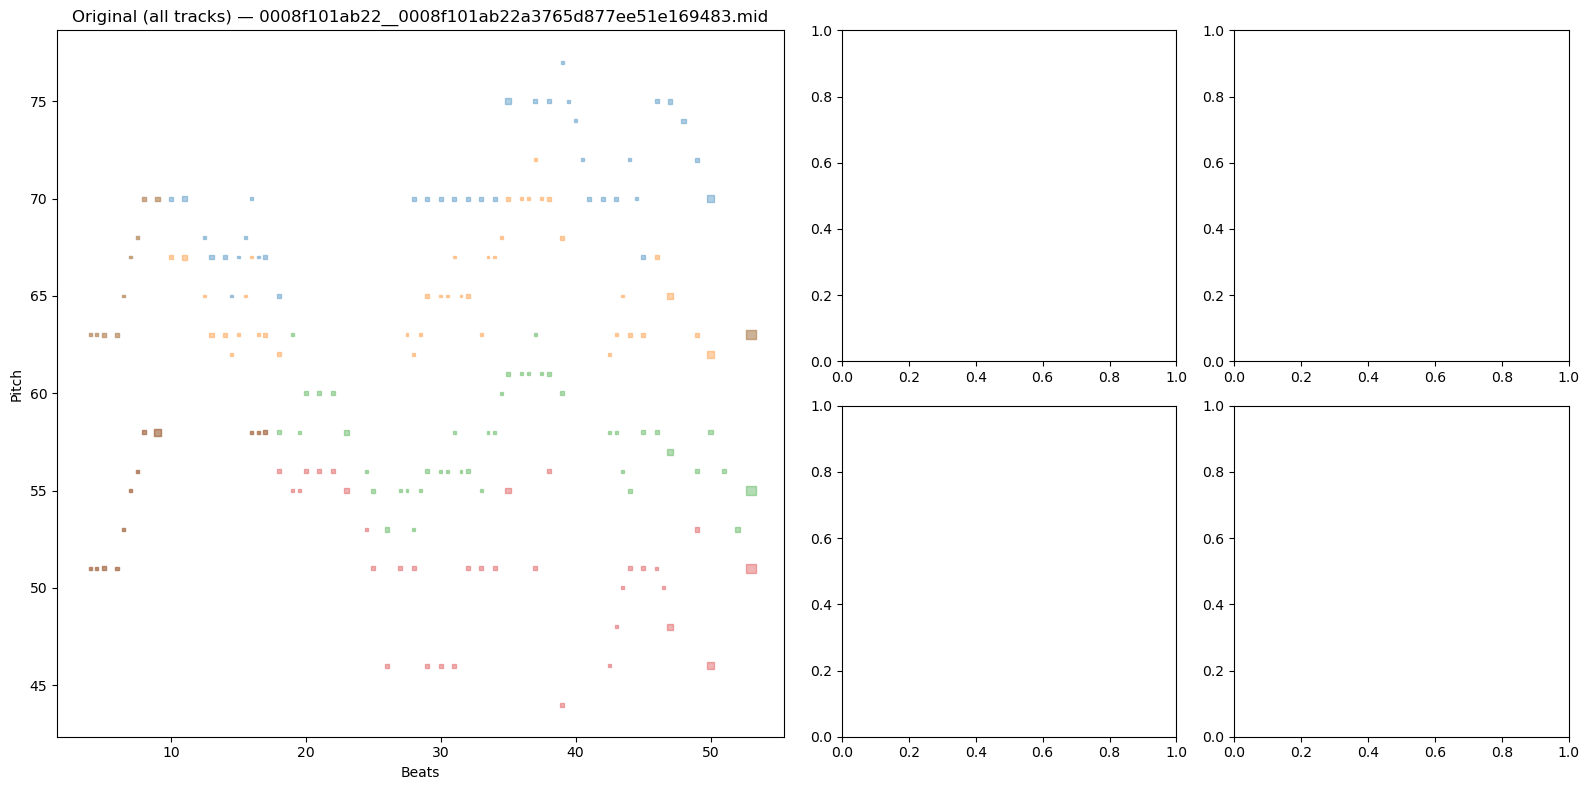

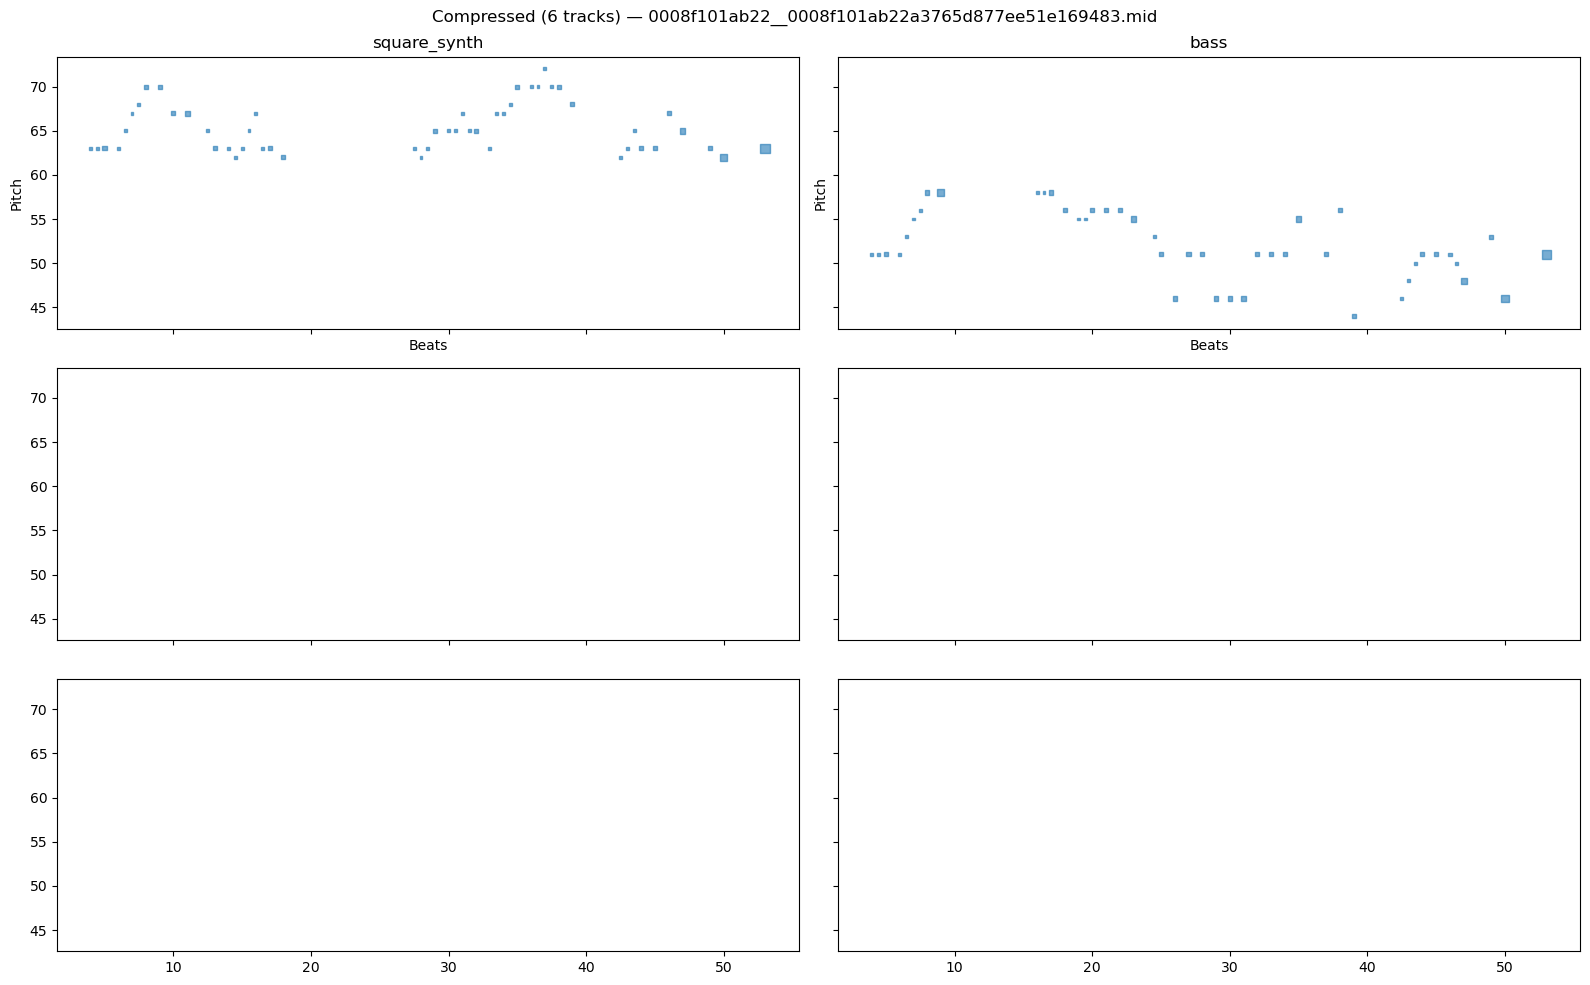

In [33]:
import matplotlib.pyplot as plt
from collections import defaultdict

def notes_to_arrays(inst: miditoolkit.Instrument, tpq: int):
    # returns start_beats, end_beats, pitch, vel
    if not inst.notes:
        return np.array([]), np.array([]), np.array([]), np.array([])
    s = np.array([n.start for n in inst.notes], dtype=np.float32) / tpq
    e = np.array([n.end for n in inst.notes], dtype=np.float32) / tpq
    p = np.array([n.pitch for n in inst.notes], dtype=np.float32)
    v = np.array([n.velocity for n in inst.notes], dtype=np.float32)
    return s, e, p, v

def plot_pianoroll(m: miditoolkit.MidiFile, title: str, ax, only_non_drum=False, max_beats=None):
    tpq = m.ticks_per_beat
    for inst in m.instruments:
        if only_non_drum and inst.is_drum:
            continue
        s,e,p,v = notes_to_arrays(inst, tpq)
        if s.size == 0:
            continue
        if max_beats is not None:
            mask = s <= max_beats
            s,e,p,v = s[mask], e[mask], p[mask], v[mask]
        # marker size ~ duration
        dur = np.maximum(e - s, 0.01)
        ax.scatter(s, p, s=10*dur, alpha=0.35, marker='s')
    ax.set_title(title)
    ax.set_xlabel("Beats")
    ax.set_ylabel("Pitch")

def plot_compressed_tracks(m: miditoolkit.MidiFile, title: str, axs, max_beats=None):
    # expects exactly 6 instruments, but will handle fewer too
    tpq = m.ticks_per_beat
    for ax, inst in zip(axs, m.instruments):
        s,e,p,v = notes_to_arrays(inst, tpq)
        if s.size and max_beats is not None:
            mask = s <= max_beats
            s,e,p,v = s[mask], e[mask], p[mask], v[mask]
        dur = np.maximum(e - s, 0.01) if s.size else np.array([])
        if s.size:
            ax.scatter(s, p, s=10*dur, alpha=0.6, marker='s')
        ax.set_title(inst.name if inst.name else f"program={inst.program} drum={inst.is_drum}")
        ax.set_xlabel("Beats")
        ax.set_ylabel("Pitch")
    plt.suptitle(title)

def compare_pianoroll_pair(orig_path: Path, comp_path: Path, max_beats=64):
    m0 = load_midi(orig_path)
    m1 = load_midi(comp_path)

    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(2, 4)

    ax0 = fig.add_subplot(gs[:, :2])
    plot_pianoroll(m0, f"Original (all tracks) — {orig_path.name}", ax0, only_non_drum=False, max_beats=max_beats)

    # compressed: 6 small panels
    axs = [fig.add_subplot(gs[i//2, 2 + (i%2)]) for i in range(4)]
    # if you want all 6 panels, expand grid; keeping 4 can be too small
    # better: show 6 in separate fig:
    plt.tight_layout()
    plt.show()

    fig2, axs2 = plt.subplots(3, 2, figsize=(16, 10), sharex=True, sharey=True)
    axs2 = axs2.reshape(-1)
    plot_compressed_tracks(m1, f"Compressed (6 tracks) — {comp_path.name}", axs2, max_beats=max_beats)
    plt.tight_layout()
    plt.show()

compare_pianoroll_pair(orig_path, comp_path, max_beats=64)


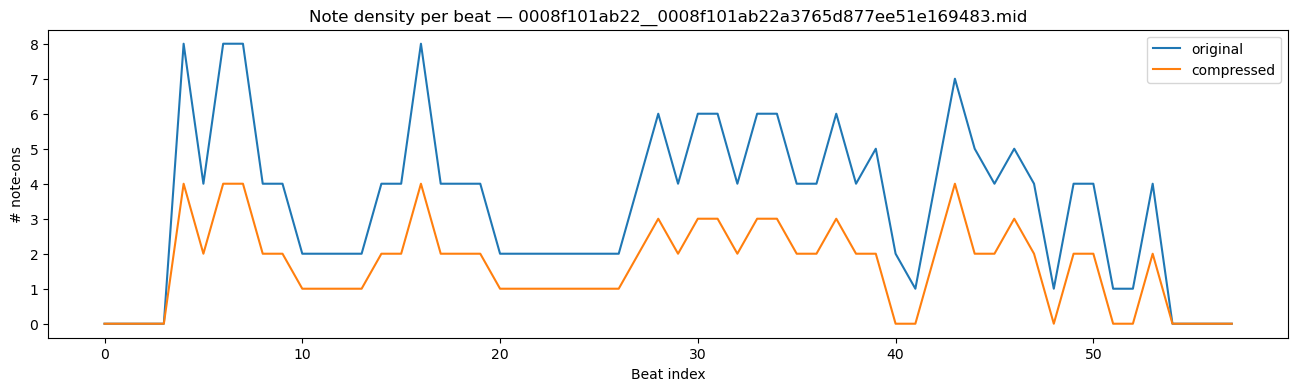

In [34]:
def note_on_hist(m: miditoolkit.MidiFile, beat_bins=256, only_non_drum=False):
    tpq = m.ticks_per_beat
    # find total beats
    max_tick = 0
    for inst in m.instruments:
        if only_non_drum and inst.is_drum:
            continue
        if inst.notes:
            max_tick = max(max_tick, max(n.end for n in inst.notes))
    total_beats = max_tick / tpq if tpq else 0
    T = int(min(beat_bins, np.ceil(total_beats))) if total_beats > 0 else beat_bins

    hist = np.zeros(T, dtype=np.int32)
    for inst in m.instruments:
        if only_non_drum and inst.is_drum:
            continue
        for n in inst.notes:
            b = int(n.start / tpq)
            if 0 <= b < T:
                hist[b] += 1
    return hist

def plot_density_pair(orig_path: Path, comp_path: Path, beat_bins=256, only_non_drum=False):
    m0 = load_midi(orig_path)
    m1 = load_midi(comp_path)
    h0 = note_on_hist(m0, beat_bins=beat_bins, only_non_drum=only_non_drum)
    h1 = note_on_hist(m1, beat_bins=beat_bins, only_non_drum=only_non_drum)

    L = min(len(h0), len(h1))
    x = np.arange(L)

    plt.figure(figsize=(16,4))
    plt.plot(x, h0[:L], label="original")
    plt.plot(x, h1[:L], label="compressed")
    plt.xlabel("Beat index")
    plt.ylabel("# note-ons")
    plt.title(f"Note density per beat — {orig_path.name}")
    plt.legend()
    plt.show()

plot_density_pair(orig_path, comp_path, beat_bins=256, only_non_drum=False)


In [ ]:
from pathlib import Path
import subprocess
from IPython.display import Audio, display
import pretty_midi
import matplotlib.pyplot as plt

RAW_DIR = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/02_b_midiminer_results")
CMP_DIR = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/03_compressed6")
OUT_AUD = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/tmp/audio_renders")
OUT_AUD.mkdir(parents=True, exist_ok=True)

SF2 = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/assets/soundfonts/TimGM6mb.sf2")
assert SF2.exists(), f"SoundFont missing: {SF2}"

def render_wav(mid: Path, wav: Path, sr=44100):
    wav.parent.mkdir(parents=True, exist_ok=True)
    cmd = ["fluidsynth", "-ni", "-F", str(wav), "-r", str(sr), str(SF2), str(mid)]
    subprocess.run(cmd, check=True, capture_output=True, text=True)
    return wav

def plot_pianoroll(mid: Path, title: str, fs_hz=50):
    pm = pretty_midi.PrettyMIDI(str(mid))
    roll = pm.get_piano_roll(fs=fs_hz)
    plt.figure(figsize=(12, 3))
    plt.imshow(roll, aspect="auto", origin="lower")
    plt.title(title)
    plt.ylabel("MIDI pitch")
    plt.xlabel("time frames")
    plt.tight_layout()
    plt.show()

def compare_one(basename: str):
    raw = RAW_DIR / basename
    cmp_ = CMP_DIR / basename
    assert raw.exists(), f"Missing raw: {raw}"
    assert cmp_.exists(), f"Missing compressed: {cmp_}"

    raw_wav = OUT_AUD / (raw.stem + "__RAW.wav")
    cmp_wav = OUT_AUD / (cmp_.stem + "__CMP.wav")

    render_wav(raw, raw_wav)
    render_wav(cmp_, cmp_wav)

    print("RAW:", raw.name)
    plot_pianoroll(raw, f"RAW pianoroll: {basename}")
    display(Audio(filename=str(raw_wav)))

    print("COMPRESSED:", cmp_.name)
    plot_pianoroll(cmp_, f"COMPRESSED pianoroll: {basename}")
    display(Audio(filename=str(cmp_wav)))

example = sorted(CMP_DIR.glob("*.mid"))[5].name
compare_one(example)


In [41]:
!export MSCORE="/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/musescore/MuseScore-Studio-4.6.5.253511702-x86_64.AppImage"
!export OPS="/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/musescore/midi_import_options.xml"
!export IN_MIDI="/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/03_compressed6/00f73583bc30__00f73583bc30336c7de4a85cf1d040cc.mid"
!export OUT_DIR="/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample/04_musescore_norm"


In [44]:
!echo $MSCORE

### Data Filtering Rules

In [ ]:
from pathlib import Path
from dataclasses import dataclass
import json
import math
import shutil
from datetime import datetime

import pandas as pd
import miditoolkit
from collections import defaultdict

# -------------------
# Paths (edit if needed)
# -------------------
SAMPLE = Path("/scratch1/e20-fyp-xlstm-music-generation/e20fyptemp1/fyp-musicgen/data/museformer_baseline/sample")
MANIFEST = SAMPLE / "logs/sample_manifest.csv"

IN_NORM_DIR   = SAMPLE / "04_musescore_norm"
OUT_FILTERED  = SAMPLE / "05_filtered"
OUT_PITCHNORM = SAMPLE / "06_pitch_norm"

OUT_FILTERED.mkdir(parents=True, exist_ok=True)
OUT_PITCHNORM.mkdir(parents=True, exist_ok=True)

# -------------------
# MuseFormer 6-track names (expected)
# -------------------
TRACK_NAMES = ["square_synth", "piano", "guitar", "string", "bass", "drum"]

# -------------------
# Filtering thresholds (Table 4)
# -------------------
TEMPO_MIN_OK = 24.0
TEMPO_MAX_OK = 200.0
PITCH_MIN_OK = 21
PITCH_MAX_OK = 108
MAX_NOTE_DUR_BEATS_OK = 16.0
EMPTY_BARS_MAX_ALLOWED = 3  # drop if >=4
MIN_NONEMPTY_TRACKS = 2

STAGE_FILTER = "05_filtered"
STAGE_PITCH  = "06_pitch_norm"


# -------------------
# Key detection profiles (Krumhansl–Kessler)
# -------------------
KK_MAJOR = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
KK_MINOR = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

def rotate(lst, k):
    k %= len(lst)
    return lst[k:] + lst[:k]

def corr(a, b):
    # cosine-like correlation
    sa = sum(x*x for x in a) ** 0.5
    sb = sum(x*x for x in b) ** 0.5
    if sa == 0 or sb == 0:
        return -1e9
    return sum(x*y for x, y in zip(a, b)) / (sa * sb)

def minimal_mod12_shift(target_pc, tonic_pc):
    # return in [-6, +5]
    d = (target_pc - tonic_pc) % 12
    if d > 6:
        d -= 12
    return d


@dataclass
class MidiStats:
    basename: str
    path: Path
    ticks_per_beat: int
    time_sigs: list
    is_4_4_only: bool
    tempo_min: float
    tempo_max: float
    pitch_min: int
    pitch_max: int
    max_note_dur_beats: float
    num_notes: int
    distinct_onsets: int
    programs_sig: tuple
    nonempty_tracks: int
    has_square_synth: bool
    empty_bars: int
    unique_pitch_count: int
    unique_dur_count: int
    num_bars: int
    duration_beats: float

    # duplication signature (paper-style)
    def dup_signature(self):
        return (
            self.num_bars,
            round(self.duration_beats, 4),
            self.num_notes,
            self.distinct_onsets,
            self.programs_sig,
            self.nonempty_tracks,
        )


def load_midi(path: Path) -> miditoolkit.MidiFile:
    return miditoolkit.MidiFile(str(path))


def extract_stats(path: Path) -> MidiStats:
    midi = load_midi(path)
    tpb = midi.ticks_per_beat

    # time signatures
    ts = getattr(midi, "time_signature_changes", []) or []
    time_sigs = [f"{x.numerator}/{x.denominator}" for x in ts] if ts else []
    # treat "no time sig" as not OK (safer for strict 4/4-only)
    is_4_4_only = (len(time_sigs) > 0) and all(s == "4/4" for s in time_sigs)

    # tempo changes
    tempos = getattr(midi, "tempo_changes", []) or []
    if tempos:
        bpm_vals = [float(t.tempo) for t in tempos]
        tempo_min = min(bpm_vals)
        tempo_max = max(bpm_vals)
    else:
        tempo_min = float("inf")
        tempo_max = float("-inf")

    # instruments signature (programs + drum)
    # MuseFormer 6-track is usually fixed, but keep generic robust signature:
    prog_list = []
    for inst in midi.instruments:
        if inst.is_drum:
            prog_list.append(("drum", 0))
        else:
            prog_list.append(("mel", inst.program) if inst.name == "square_synth" else ("inst", inst.program))
    programs_sig = tuple(sorted(prog_list))

    # collect notes (non-drum + drum for note count, but pitch filters apply to non-drum typically)
    all_notes = []
    non_drum_notes = []
    onsets = set()
    pitches = []
    durs = []

    max_end_tick = 0

    # track non-empty count + square_synth presence
    nonempty_tracks = 0
    has_square = False

    for inst in midi.instruments:
        if inst.notes:
            nonempty_tracks += 1
        if inst.name == "square_synth" and len(inst.notes) > 0:
            has_square = True

        for n in inst.notes:
            all_notes.append(n)
            onsets.add(int(n.start))
            max_end_tick = max(max_end_tick, int(n.end))
            if not inst.is_drum:
                non_drum_notes.append(n)
                pitches.append(int(n.pitch))
                durs.append(int(n.end) - int(n.start))

    num_notes = len(all_notes)
    distinct_onsets = len(onsets)

    if non_drum_notes:
        pitch_min = min(pitches)
        pitch_max = max(pitches)
        max_note_dur_beats = max(d / tpb for d in durs)
        unique_pitch_count = len(set(pitches))
        unique_dur_count = len(set(durs))
    else:
        pitch_min = 999
        pitch_max = -999
        max_note_dur_beats = float("inf")
        unique_pitch_count = 0
        unique_dur_count = 0

    # duration in beats/bars (assume 4/4 bars = 4 beats)
    duration_beats = max_end_tick / tpb if tpb > 0 else 0.0
    num_bars = int(math.ceil(duration_beats / 4.0)) if duration_beats > 0 else 0

    # empty bars (>=4 bars empty → drop)
    # define empty bar as: no note onset (any track, including drums) inside bar range
    empty_bars = 0
    bar_ticks = 4 * tpb
    if bar_ticks > 0 and num_bars > 0:
        # map starts for fast lookup
        starts = sorted(onsets)
        si = 0
        for b in range(num_bars):
            bs = b * bar_ticks
            be = (b + 1) * bar_ticks
            # advance pointer to first onset >= bs
            while si < len(starts) and starts[si] < bs:
                si += 1
            if si >= len(starts) or starts[si] >= be:
                empty_bars += 1

    return MidiStats(
        basename=path.name,
        path=path,
        ticks_per_beat=tpb,
        time_sigs=time_sigs,
        is_4_4_only=is_4_4_only,
        tempo_min=tempo_min,
        tempo_max=tempo_max,
        pitch_min=pitch_min,
        pitch_max=pitch_max,
        max_note_dur_beats=max_note_dur_beats,
        num_notes=num_notes,
        distinct_onsets=distinct_onsets,
        programs_sig=programs_sig,
        nonempty_tracks=nonempty_tracks,
        has_square_synth=has_square,
        empty_bars=empty_bars,
        unique_pitch_count=unique_pitch_count,
        unique_dur_count=unique_dur_count,
        num_bars=num_bars,
        duration_beats=duration_beats,
    )


def filter_reason(s: MidiStats):
    # returns None if pass, else a string drop reason
    if not s.is_4_4_only:
        return "filter_not_4_4"
    if s.nonempty_tracks < MIN_NONEMPTY_TRACKS:
        return "filter_lt_2_tracks"
    if not s.has_square_synth:
        return "filter_no_square_synth"
    if not (TEMPO_MIN_OK <= s.tempo_min <= s.tempo_max <= TEMPO_MAX_OK):
        return "filter_tempo_out_of_range"
    if not (PITCH_MIN_OK <= s.pitch_min and s.pitch_max <= PITCH_MAX_OK):
        return "filter_pitch_out_of_range"
    if s.max_note_dur_beats > MAX_NOTE_DUR_BEATS_OK:
        return "filter_note_too_long"
    if s.empty_bars >= 4:
        return "filter_too_many_empty_bars"
    # degenerate: all pitches or all durations the same (paper wording)
    if s.unique_pitch_count == 1 or s.unique_dur_count == 1:
        return "filter_degenerate_pitch_or_dur"
    return None


def pitch_class_histogram(midi: miditoolkit.MidiFile):
    # duration-weighted pitch class histogram over NON-DRUM notes
    hist = [0.0] * 12
    tpb = midi.ticks_per_beat
    for inst in midi.instruments:
        if inst.is_drum:
            continue
        for n in inst.notes:
            pc = int(n.pitch) % 12
            dur_beats = (int(n.end) - int(n.start)) / tpb if tpb > 0 else 0.0
            hist[pc] += max(dur_beats, 0.0)
    return hist


def detect_key_and_shift(midi: miditoolkit.MidiFile):
    hist = pitch_class_histogram(midi)
    if sum(hist) == 0:
        return None, None, 0  # no pitched content

    # best major
    best_M = (-1e9, None)  # (score, tonic)
    for tonic in range(12):
        score = corr(hist, rotate(KK_MAJOR, tonic))
        if score > best_M[0]:
            best_M = (score, tonic)

    # best minor
    best_m = (-1e9, None)
    for tonic in range(12):
        score = corr(hist, rotate(KK_MINOR, tonic))
        if score > best_m[0]:
            best_m = (score, tonic)

    if best_M[0] >= best_m[0]:
        mode = "major"
        tonic = best_M[1]
        target = 0  # C
    else:
        mode = "minor"
        tonic = best_m[1]
        target = 9  # A

    shift = minimal_mod12_shift(target, tonic)
    return mode, tonic, shift


def apply_pitch_norm(midi: miditoolkit.MidiFile, shift: int):
    # transpose non-drum notes by shift semitones
    for inst in midi.instruments:
        if inst.is_drum:
            continue
        for n in inst.notes:
            n.pitch = int(n.pitch) + int(shift)

    # octave adjust to fit [21,108] if possible (preserve pitch class)
    # do global shift by +/- 12
    all_pitched = [n.pitch for inst in midi.instruments if not inst.is_drum for n in inst.notes]
    if not all_pitched:
        return True  # nothing to do

    mn = min(all_pitched)
    mx = max(all_pitched)

    # shift up if too low
    while mn < PITCH_MIN_OK:
        for inst in midi.instruments:
            if inst.is_drum:
                continue
            for n in inst.notes:
                n.pitch += 12
        mn += 12
        mx += 12
        if mx > 127:
            return False

    # shift down if too high
    while mx > PITCH_MAX_OK:
        for inst in midi.instruments:
            if inst.is_drum:
                continue
            for n in inst.notes:
                n.pitch -= 12
        mn -= 12
        mx -= 12
        if mn < 0:
            return False

    # final sanity (MIDI pitch bounds)
    all_pitched = [n.pitch for inst in midi.instruments if not inst.is_drum for n in inst.notes]
    if any(p < 0 or p > 127 for p in all_pitched):
        return False
    return True


def update_manifest(df: pd.DataFrame, updates: dict):
    # updates: basename -> dict(columns...)
    if "raw_basename" not in df.columns:
        df["raw_basename"] = df["raw_path"].astype(str).map(lambda p: Path(p).name)

    for col in set(k for u in updates.values() for k in u.keys()):
        if col not in df.columns:
            df[col] = pd.NA

    for b, cols in updates.items():
        mask = df["raw_basename"].astype(str) == b
        for k, v in cols.items():
            df.loc[mask, k] = v


def main():
    midi_files = sorted(list(IN_NORM_DIR.glob("*.mid")) + list(IN_NORM_DIR.glob("*.midi")))
    print("[INPUT] normalized MIDIs:", len(midi_files))

    df = pd.read_csv(MANIFEST)
    backup = MANIFEST.with_suffix(f".backup_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
    df.to_csv(backup, index=False)
    print("[MANIFEST] backup:", backup)

    # 1) Extract stats for all
    stats = []
    failed = []
    for p in midi_files:
        try:
            stats.append(extract_stats(p))
        except Exception as e:
            failed.append((p.name, str(e)))

    print("[STATS] ok:", len(stats), "failed:", len(failed))

    # 2) Duplicate removal signature
    sig_to_first = {}
    is_dup = {}
    for s in stats:
        sig = s.dup_signature()
        if sig not in sig_to_first:
            sig_to_first[sig] = s.basename
            is_dup[s.basename] = False
        else:
            is_dup[s.basename] = True

    # 3) Apply filtering rules
    keep = []
    drop_reason_map = {}

    for s in stats:
        if is_dup.get(s.basename, False):
            drop_reason_map[s.basename] = "filter_duplicate_signature"
            continue

        reason = filter_reason(s)
        if reason is None:
            keep.append(s)
        else:
            drop_reason_map[s.basename] = reason

    print("[FILTER] keep:", len(keep), "drop:", len(drop_reason_map))

    # 4) Copy kept -> 05_filtered (preserve exact file bytes)
    kept_basenames = set(s.basename for s in keep)
    for s in keep:
        shutil.copy2(s.path, OUT_FILTERED / s.basename)

    # 5) Pitch norm -> 06_pitch_norm
    pitch_updates = {}
    pitch_drops = {}

    for s in keep:
        src = OUT_FILTERED / s.basename
        dst = OUT_PITCHNORM / s.basename

        try:
            midi = load_midi(src)
            mode, tonic, shift = detect_key_and_shift(midi)
            ok = apply_pitch_norm(midi, shift)
            if not ok:
                pitch_drops[s.basename] = "pitchnorm_out_of_range"
                continue
            midi.dump(str(dst))
            pitch_updates[s.basename] = {
                "pitchnorm_mode": mode,
                "pitchnorm_tonic_pc": tonic,
                "pitchnorm_semitones": shift,
                "pitchnorm_path": str(dst),
            }
        except Exception as e:
            pitch_drops[s.basename] = f"pitchnorm_error:{e}"

    print("[PITCH] ok:", len(pitch_updates), "drop:", len(pitch_drops))

    # 6) Update manifest
    updates = {}

    # filtering updates
    for s in stats:
        b = s.basename
        # if not in normalized dir list, ignore
        if b not in [x.name for x in midi_files]:
            continue

        if b in kept_basenames:
            updates[b] = {
                "stage": STAGE_FILTER,
                "status": "ok",
                "drop_reason": pd.NA,
                "error_msg": pd.NA,
                "mscore_norm_path": str(IN_NORM_DIR / b),
                "filtered_path": str(OUT_FILTERED / b),
                "filter_is_duplicate": bool(is_dup.get(b, False)),
                "filter_empty_bars": s.empty_bars,
                "filter_num_bars": s.num_bars,
                "filter_duration_beats": s.duration_beats,
                "filter_nonempty_tracks": s.nonempty_tracks,
                "filter_pitch_min": s.pitch_min,
                "filter_pitch_max": s.pitch_max,
                "filter_tempo_min": s.tempo_min,
                "filter_tempo_max": s.tempo_max,
                "filter_max_note_dur_beats": s.max_note_dur_beats,
                "filter_distinct_onsets": s.distinct_onsets,
                "filter_num_notes": s.num_notes,
            }
        else:
            reason = drop_reason_map.get(b, "filter_unknown")
            updates[b] = {
                "stage": STAGE_FILTER,
                "status": "dropped",
                "drop_reason": reason,
                "error_msg": pd.NA,
                "mscore_norm_path": str(IN_NORM_DIR / b),
                "filtered_path": pd.NA,
            }

    # pitch norm updates (advance stage only for those that succeed)
    for b, cols in pitch_updates.items():
        updates.setdefault(b, {})
        updates[b].update({
            "stage": STAGE_PITCH,
            "status": "ok",
            "drop_reason": pd.NA,
            "error_msg": pd.NA,
        })
        updates[b].update(cols)

    for b, reason in pitch_drops.items():
        updates.setdefault(b, {})
        updates[b].update({
            "stage": STAGE_PITCH,
            "status": "dropped",
            "drop_reason": reason,
            "error_msg": pd.NA,
        })

    update_manifest(df, updates)
    df.to_csv(MANIFEST, index=False)
    print("[MANIFEST] updated:", MANIFEST)

    if failed:
        print("\n[WARN] some MIDI files failed to parse stats:")
        for n, e in failed[:10]:
            print("  ", n, "->", e)

if __name__ == "__main__":
    main()
